In [1]:
import scipy.io as read
case1 = read.loadmat('case1.mat')
case2 = read.loadmat('case2.mat')
case3 = read.loadmat('case3.mat')
case4 = read.loadmat('case4.mat')

In [2]:
#get total data
data1=case1['case1']
data2=case2['case2']
data3=case3['case3']
data4=case4['case4']

In [3]:
import numpy as np
#load all data and label data
data = []
labels = []
for i in range(int(data1.shape[3])):
    data.append(data1[:,:,:,i])
    labels.append(0)

for j in range(int(data2.shape[3])):
    data.append(data2[:,:,:,j])
    labels.append(1)
for k in range(int(data3.shape[3])):
    data.append(data3[:,:,:,k])
    labels.append(2)
for m in range(int(data4.shape[3])):
    data.append(data4[:,:,:,m])
    labels.append(3)
data = np.array(data)
labels = np.array(labels)

In [4]:
#Split data to train
data = np.array(data)
lanels = np.array(labels)
from sklearn.model_selection import train_test_split
x_train_val, x_test, y_train_val, y_test = train_test_split(data, labels, test_size=0.1,
                                                 random_state=42)
x_train_val.shape 
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.1,
                                                  random_state=42)
x_train.shape


(4438, 40, 30, 1)

In [5]:
import random

def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

In [6]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape 
x_train_2 = pairs_train[:, 1]

In [7]:
x_val_1 = pairs_val[:, 0]  # x_val_1.shape 
x_val_2 = pairs_val[:, 1]

In [8]:
x_test_1 = pairs_test[:, 0]  # x_test_1.shape 
x_test_2 = pairs_test[:, 1]

In [10]:
import tensorflow as tf
#Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

input = tf.keras.layers.Input((40, 30, 1))
#x = tf.keras.layers.BatchNormalization()(input)
x = tf.keras.layers.Conv2D(16, (2, 2), activation="relu")(input)
x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Conv2D(32, (5, 5), activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.5)(x)


x = tf.keras.layers.Conv2D(64, (5, 5), activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.5)(x)



# x = tf.keras.layers.Conv2D(16, (5, 5), activation="tanh")(x)
# x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.Dense(32)(x)
embedding_network = tf.keras.Model(input, x)


input_1 = tf.keras.layers.Input((40, 30, 1))
input_2 = tf.keras.layers.Input((40, 30, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = tf.keras.layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [12]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'constrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [14]:
epochs = 300
batch_size = 64
margin = 1  # Margin for constrastive loss.
siamese.compile(loss=loss(margin=margin), optimizer="Adam", metrics=["accuracy"])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40, 30, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 40, 30, 1)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 32)           2733264     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]                

In [15]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/300
139/139 [==============================] - 28s 193ms/step - loss: 0.1625 - accuracy: 0.7781 - val_loss: 0.1339 - val_accuracy: 0.7976
Epoch 2/300
139/139 [==============================] - 26s 188ms/step - loss: 0.1100 - accuracy: 0.8757 - val_loss: 0.0973 - val_accuracy: 0.8755
Epoch 3/300
139/139 [==============================] - 26s 188ms/step - loss: 0.0758 - accuracy: 0.9206 - val_loss: 0.0644 - val_accuracy: 0.9281
Epoch 4/300
139/139 [==============================] - 26s 187ms/step - loss: 0.0514 - accuracy: 0.9543 - val_loss: 0.0491 - val_accuracy: 0.9443
Epoch 5/300
139/139 [==============================] - 26s 186ms/step - loss: 0.0384 - accuracy: 0.9650 - val_loss: 0.0329 - val_accuracy: 0.9666
Epoch 6/300
139/139 [==============================] - 26s 186ms/step - loss: 0.0294 - accuracy: 0.9733 - val_loss: 0.0331 - val_accuracy: 0.9555
Epoch 7/300
139/139 [==============================] - 26s 189ms/step - loss: 0.0236 - accuracy: 0.9796 - val_loss: 0.0201 -

Epoch 57/300
139/139 [==============================] - 49s 349ms/step - loss: 0.0026 - accuracy: 0.9970 - val_loss: 0.0084 - val_accuracy: 0.9868
Epoch 58/300
139/139 [==============================] - 48s 347ms/step - loss: 0.0035 - accuracy: 0.9958 - val_loss: 0.0044 - val_accuracy: 0.9949
Epoch 59/300
139/139 [==============================] - 47s 342ms/step - loss: 0.0021 - accuracy: 0.9976 - val_loss: 0.0051 - val_accuracy: 0.9939
Epoch 60/300
139/139 [==============================] - 48s 347ms/step - loss: 0.0021 - accuracy: 0.9974 - val_loss: 0.0070 - val_accuracy: 0.9889
Epoch 61/300
139/139 [==============================] - 49s 353ms/step - loss: 0.0019 - accuracy: 0.9975 - val_loss: 0.0072 - val_accuracy: 0.9868
Epoch 62/300
139/139 [==============================] - 47s 340ms/step - loss: 0.0019 - accuracy: 0.9979 - val_loss: 0.0068 - val_accuracy: 0.9919
Epoch 63/300
139/139 [==============================] - 48s 346ms/step - loss: 0.0024 - accuracy: 0.9970 - val_loss: 0

139/139 [==============================] - 49s 354ms/step - loss: 9.6497e-04 - accuracy: 0.9989 - val_loss: 0.0059 - val_accuracy: 0.9939
Epoch 113/300
139/139 [==============================] - 49s 351ms/step - loss: 0.0016 - accuracy: 0.9982 - val_loss: 0.0083 - val_accuracy: 0.9899
Epoch 114/300
139/139 [==============================] - 49s 355ms/step - loss: 0.0015 - accuracy: 0.9979 - val_loss: 0.0021 - val_accuracy: 0.9980
Epoch 115/300
139/139 [==============================] - 48s 345ms/step - loss: 0.0014 - accuracy: 0.9983 - val_loss: 0.0043 - val_accuracy: 0.9949
Epoch 116/300
139/139 [==============================] - 49s 353ms/step - loss: 0.0015 - accuracy: 0.9980 - val_loss: 0.0054 - val_accuracy: 0.9939
Epoch 117/300
139/139 [==============================] - 49s 354ms/step - loss: 0.0013 - accuracy: 0.9982 - val_loss: 0.0032 - val_accuracy: 0.9949
Epoch 118/300
139/139 [==============================] - 49s 353ms/step - loss: 0.0014 - accuracy: 0.9981 - val_loss: 0.00

139/139 [==============================] - 49s 356ms/step - loss: 0.0012 - accuracy: 0.9983 - val_loss: 0.0021 - val_accuracy: 0.9970
Epoch 168/300
139/139 [==============================] - 48s 344ms/step - loss: 0.0014 - accuracy: 0.9983 - val_loss: 0.0026 - val_accuracy: 0.9970
Epoch 169/300
139/139 [==============================] - 49s 351ms/step - loss: 0.0023 - accuracy: 0.9971 - val_loss: 0.0087 - val_accuracy: 0.9889
Epoch 170/300
139/139 [==============================] - 49s 355ms/step - loss: 9.3460e-04 - accuracy: 0.9988 - val_loss: 0.0014 - val_accuracy: 0.9980
Epoch 171/300
139/139 [==============================] - 49s 353ms/step - loss: 4.3368e-04 - accuracy: 0.9994 - val_loss: 0.0027 - val_accuracy: 0.9970
Epoch 172/300
139/139 [==============================] - 49s 349ms/step - loss: 0.0013 - accuracy: 0.9983 - val_loss: 0.0019 - val_accuracy: 0.9980
Epoch 173/300
139/139 [==============================] - 49s 351ms/step - loss: 9.1157e-04 - accuracy: 0.9990 - val_lo

139/139 [==============================] - 49s 355ms/step - loss: 0.0013 - accuracy: 0.9981 - val_loss: 0.0016 - val_accuracy: 0.9970
Epoch 222/300
139/139 [==============================] - 49s 355ms/step - loss: 7.5048e-04 - accuracy: 0.9991 - val_loss: 0.0016 - val_accuracy: 0.9980
Epoch 223/300
139/139 [==============================] - 48s 346ms/step - loss: 7.0615e-04 - accuracy: 0.9991 - val_loss: 0.0022 - val_accuracy: 0.9970
Epoch 224/300
139/139 [==============================] - 48s 342ms/step - loss: 0.0012 - accuracy: 0.9982 - val_loss: 0.0013 - val_accuracy: 0.9980
Epoch 225/300
139/139 [==============================] - 49s 350ms/step - loss: 8.4042e-04 - accuracy: 0.9990 - val_loss: 7.1591e-04 - val_accuracy: 0.9980
Epoch 226/300
139/139 [==============================] - 49s 353ms/step - loss: 7.0164e-04 - accuracy: 0.9990 - val_loss: 8.0140e-04 - val_accuracy: 0.9990
Epoch 227/300
139/139 [==============================] - 50s 360ms/step - loss: 9.5579e-04 - accuracy:

139/139 [==============================] - 49s 351ms/step - loss: 5.6748e-04 - accuracy: 0.9992 - val_loss: 0.0013 - val_accuracy: 0.9990
Epoch 275/300
139/139 [==============================] - 50s 357ms/step - loss: 7.7843e-04 - accuracy: 0.9988 - val_loss: 0.0021 - val_accuracy: 0.9970
Epoch 276/300
139/139 [==============================] - 48s 348ms/step - loss: 8.1680e-04 - accuracy: 0.9990 - val_loss: 0.0020 - val_accuracy: 0.9980
Epoch 277/300
139/139 [==============================] - 49s 354ms/step - loss: 0.0014 - accuracy: 0.9984 - val_loss: 0.0014 - val_accuracy: 0.9990
Epoch 278/300
139/139 [==============================] - 48s 346ms/step - loss: 7.0782e-04 - accuracy: 0.9990 - val_loss: 0.0010 - val_accuracy: 0.9990
Epoch 279/300
139/139 [==============================] - 50s 358ms/step - loss: 0.0012 - accuracy: 0.9984 - val_loss: 1.0499e-04 - val_accuracy: 1.0000
Epoch 280/300
139/139 [==============================] - 50s 361ms/step - loss: 4.4097e-04 - accuracy: 0.9

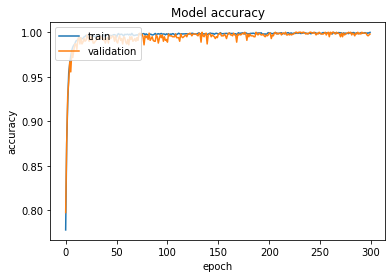

In [19]:
from matplotlib import pyplot as plt

def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")


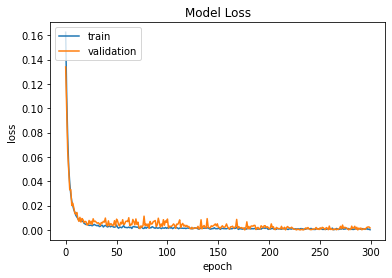

In [21]:
from matplotlib import pyplot as plt

def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="loss", title="Model Loss")
